In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from fastai import vision, metrics, torch_core, callbacks, widgets

### Building the image dataset

Paste the following JS code into the javascript console on the Google Images search results page, copy the url list, and paste into a file `urls_{label}.txt`.
```
(function(e, s) {
    e.src = s;
    e.onload = function() {
        jQuery.noConflict();
        jQuery('<style type="text/css"> .remove { opacity:0.3;}\n .urlmodal {padding: 10px; background-color: #eee; position: fixed; bottom: 0; right: 0; height: 100px; width: 300px; z-index: 1000;} .urlmodal textarea {width: 100%; height: 250px;}</style>').appendTo('head');
        jQuery('<div class="urlmodal"><h3>Let\'s create a dataset</h3><textarea>Scoll all the way down\nClick "Show more images"\nScroll more\nClick on the images you want to remove from the dataset\nThe urls will appear in this box for you to copy.</textarea></div>').appendTo('body');

        jQuery('#rg').on('click', '.rg_di', function() {
            jQuery(this).toggleClass('remove');
            updateUrls();
            return false;
        });
        jQuery(window).scroll(updateUrls);
        jQuery('.urlmodal textarea').focus(function() {updateUrls(); setTimeout(selectText, 100)}).mouseup(function() {return false;});

        function updateUrls() {
            var urls = Array.from(document.querySelectorAll('.rg_di:not(.remove) .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
            var search_term = jQuery('.gsfi').val();
            jQuery('.urlmodal textarea').val(urls.join("\n"));
            jQuery('.urlmodal h3').html(search_term + ": " + urls.length);
        }

        function selectText() {
            jQuery('.urlmodal textarea').select();
        }
    };
    document.head.appendChild(e);
})(document.createElement('script'), '//code.jquery.com/jquery-latest.min.js');
```

In [3]:
path = vision.Path('data')

In [4]:
import re

regex = r'urls_(.+)\.txt$'
txt_files = [f for f in os.listdir(path) if re.search(regex, f)]
classes = [re.search(regex, f).group(1) for f in txt_files]
classes

['cougar', 'leopard', 'panther', 'bobcat']

In [5]:
def download_imgs(path, classes):
    for c in classes:
        print(c + '..')
        folder = c
        file = 'urls_' + c + '.txt'
        dest = path/folder
        dest.mkdir(parents=True, exist_ok=True)
        vision.download_images(path/file, dest)
        vision.verify_images(dest, delete=True)
        
download_imgs(path, classes)

cougar..


Image data/cougar/00000187.jpg has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/cougar/00000069.jpg'>
cannot identify image file <_io.BufferedReader name='data/cougar/00000185.jpg'>
Image data/cougar/00000145.png has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/cougar/00000129.jpg'>
Image data/cougar/00000166.png has 1 instead of 3 channels
leopard..


Error https://media.mehrnews.com/d/2018/03/18/4/2744865.jpg HTTPSConnectionPool(host='media.mehrnews.com', port=443): Max retries exceeded with url: /d/2018/03/18/4/2744865.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fd6dc1e6860>, 'Connection to media.mehrnews.com timed out. (connect timeout=4)'))
Error https://media.mehrnews.com/d/2018/01/13/3/2687680.jpg HTTPSConnectionPool(host='media.mehrnews.com', port=443): Max retries exceeded with url: /d/2018/01/13/3/2687680.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fd6dc1e6940>, 'Connection to media.mehrnews.com timed out. (connect timeout=4)'))


cannot identify image file <_io.BufferedReader name='data/leopard/00000069.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000083.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000153.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000193.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000078.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000079.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000189.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000209.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000044.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000228.jpg'>
cannot identify image file <_io.BufferedReader name='data/leopard/00000157.jpg'>
Image data/leopard/00000118.jpg has 4 instead of 3 channels
panther..


Error https://www.zooportraits.com/wp-content/uploads/2018/05/Black-Panther-Panthera-Pardus.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error https://zooportraits.com/wp-content/uploads/2018/06/shutterstock_267363809.jpg ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


Image data/panther/00000099.jpg has 1 instead of 3 channels
Image data/panther/00000088.jpg has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/panther/00000068.jpg'>
Image data/panther/00000077.gif has 1 instead of 3 channels
Image data/panther/00000069.png has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/panther/00000072.jpg'>
cannot identify image file <_io.BufferedReader name='data/panther/00000058.jpg'>
cannot identify image file <_io.BufferedReader name='data/panther/00000039.jpg'>
bobcat..


Error https://img.washingtonpost.com/rf/image_480w/2010-2019/WashingtonPost/2017/05/22/KidsPost/Images/Bobcat_Released_Vermont_87655-5c3a7.jpg?uuid=6PQiZD8KEeetujlO5np1gg HTTPSConnectionPool(host='img.washingtonpost.com', port=443): Read timed out. (read timeout=4)
Error https://triblive.com/csp/mediapool/sites/dt.common.streams.StreamServer.cls?STREAMOID=pVwyGUgPyleMLiIVkoS9j8$daE2N3K4ZzOUsqbU5sYtj1Oim0ZioxxtNWuNbo0zuWCsjLu883Ygn4B49Lvm9bPe2QeMKQdVeZmXF$9l$4uCZ8QDXhaHEp3rvzXRJFdy0KqPHLoMevcTLo3h8xh70Y6N_U_CryOsw6FTOdKL_jpQ-&amp;CONTENTTYPE=image/jpeg HTTPSConnectionPool(host='legacy.triblive.com', port=443): Read timed out. (read timeout=4)
Error https://img.washingtonpost.com/rf/image_480w/2010-2019/WashingtonPost/2017/01/30/Local/Images/bobcat_63.JPG?uuid=ZsfDIuccEeaQPZsR7X2NKg HTTPSConnectionPool(host='img.washingtonpost.com', port=443): Read timed out. (read timeout=4)
Error https://www.wfaa.com/img/resize/content.wfaa.com/photo/2016/09/27/0927%20bobcat%20party%206_1475037003846_6

cannot identify image file <_io.BufferedReader name='data/bobcat/00000047.jpg'>
cannot identify image file <_io.BufferedReader name='data/bobcat/00000102.jpg'>
Image data/bobcat/00000077.gif has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bobcat/00000067.jpg'>
cannot identify image file <_io.BufferedReader name='data/bobcat/00000109.jpg'>
Image data/bobcat/00000083.png has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bobcat/00000076.jpg'>
Image data/bobcat/00000068.png has 1 instead of 3 channels
cannot identify image file <_io.BufferedReader name='data/bobcat/00000157.jpg'>


### Exploring images

In [76]:
IMG_SIZE = 224
BATCH_SIZE = 32

tfms = vision.get_transforms(max_warp=None)
data = vision.ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=tfms, size=IMG_SIZE, bs=BATCH_SIZE, num_workers=4)
data = data.normalize(vision.imagenet_stats)

data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bobcat', 'cougar', 'leopard', 'panther'], 4, 517, 129)

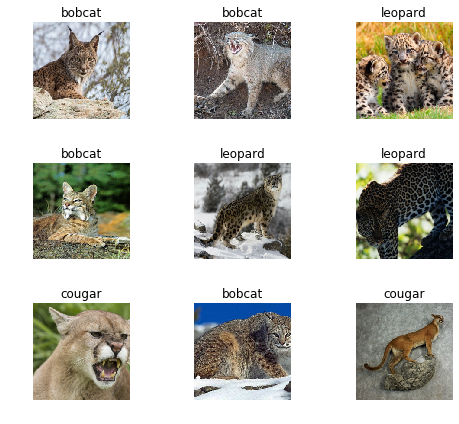

In [18]:
data.show_batch(rows=3, figsize=(7,6))

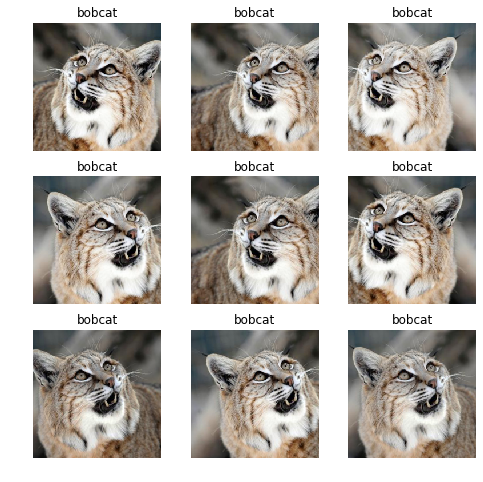

In [28]:
# Visualize transforms
def plot_tfms(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)
    
vision.plot_multi(plot_tfms, 3, 3, figsize=(8,8))

In [82]:
learn = vision.create_cnn(data, vision.models.resnet34, metrics=metrics.error_rate)

In [21]:
def get_similar_pairs(layer_ls=[0, 7, 2]):
    hook = callbacks.hook_output(learn.model[layer_ls[0]][layer_ls[1]][layer_ls[2]])
    train_acts = widgets.DatasetFormatter.get_actns(learn, hook=hook, dl=learn.data.fix_dl)
    valid_acts = widgets.DatasetFormatter.get_actns(learn, hook=hook, dl=learn.data.valid_dl)
    ds_items = list(learn.data.fix_dl.items) + list(learn.data.valid_dl.items)
    ds_acts = vision.torch.cat((train_acts, valid_acts), 0)
    scores = widgets.DatasetFormatter.comb_similarity(ds_acts, ds_acts)
    idxs = widgets.DatasetFormatter.largest_indices(scores, len(scores))
    pairs = [(idxs[0][i], idxs[1][i]) for i in range(len(idxs[0]))]
    pair_scores = [((ds_items[pair[0]], ds_items[pair[1]]), float(scores[pair])) for pair in pairs]
    hook.remove()
    return pair_scores

pair_scores = get_similar_pairs()

Getting activations...


Getting activations...


Computing similarities...


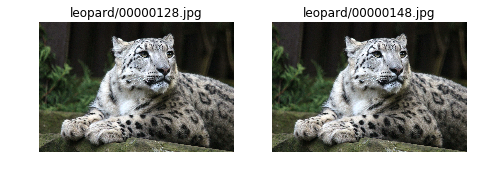

In [23]:
def imshow_similar_pair(pair_scores, pair_idx):
    f = plt.figure(figsize=(16, 4))
    f.tight_layout()
    
    for i, fpath in enumerate(pair_scores[pair_idx][0]):
        img = Image.open(fpath)
        
        sp = f.add_subplot(1, 4, i+1)
        sp.axis('off')
        sp.set_title(vision.Path(*fpath.parts[1:]))
        plt.imshow(img)
        
imshow_similar_pair(pair_scores, 1)

In [24]:
from collections import defaultdict

def imshow_dissimilar_imgs(pair_scores, batch_idx, show_n=4):
    # Show an image with a dissimilar embedding
    scores = defaultdict(int)
    for pair, score in pair_scores:
        scores[pair[0]] += score
        scores[pair[1]] += score
    scores = sorted(scores.items(), key=lambda x: x[1])
    
    f = plt.figure(figsize=(16, 4))
    f.tight_layout()
    
    for i, (fpath, score) in enumerate(scores[show_n*batch_idx:show_n*(batch_idx+1)]):
        img = Image.open(fpath)

        sp = f.add_subplot(1, show_n, i+1)
        sp.axis('off')
        sp.set_title(vision.Path(*fpath.parts[1:]))
        plt.imshow(img)
        
imshow_dissimilar_imgs(pair_scores, 0)

### Fitting the classifier

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


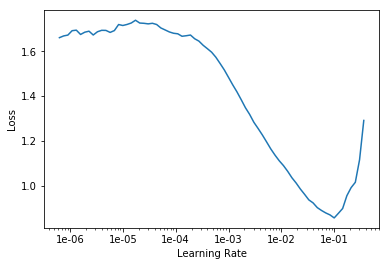

In [25]:
learn.lr_find()
learn.recorder.plot()

In [83]:
learn.fit_one_cycle(5, 1e-03)

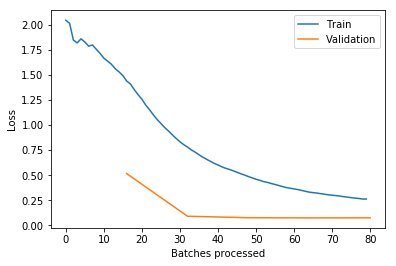

In [84]:
learn.recorder.plot_losses()

In [85]:
learn.save('stage-1-34')

In [86]:
learn.load('stage-1-34');

In [87]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


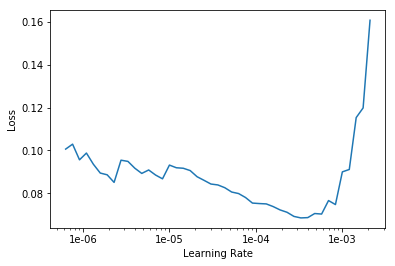

In [50]:
learn.lr_find()
learn.recorder.plot()

In [88]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-04))

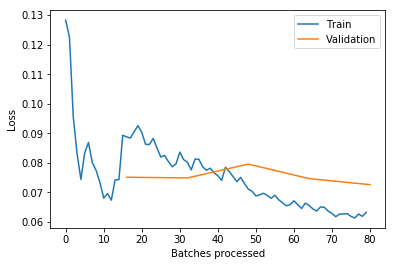

In [89]:
learn.recorder.plot_losses()

In [90]:
learn.save('stage-2-34')

In [91]:
learn.load('stage-2-34');

In [92]:
# Export inference learner
learn.export()

### Evaluation of the classifier

In [93]:
interp = vision.ClassificationInterpretation.from_learner(learn)

In [94]:
interp.plot_confusion_matrix()

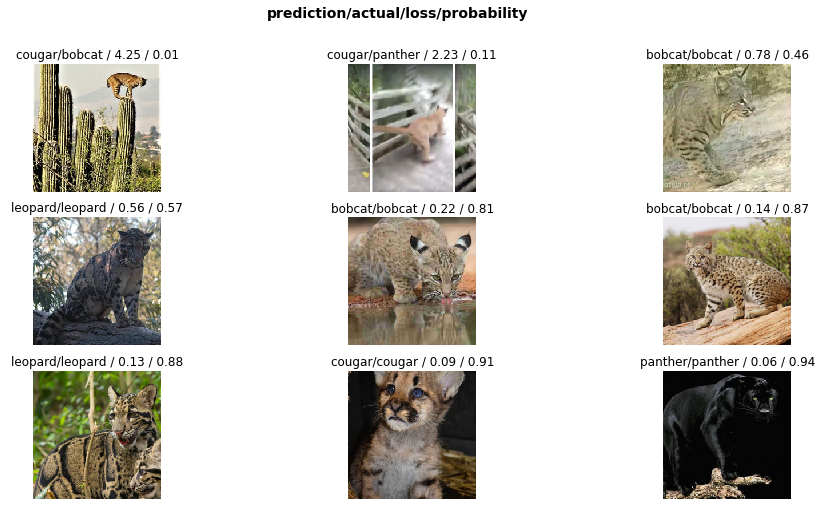

In [95]:
interp.plot_top_losses(9, figsize=(16, 8))

### Exploration: Grad-CAM

In [96]:
img_url = 'https://images.unsplash.com/photo-1513453214162-57fe6bc66037?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1053&q=80'

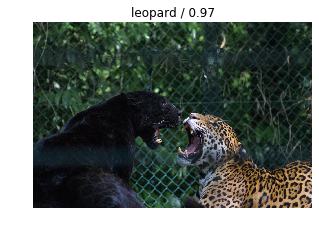

In [97]:
import requests
from io import BytesIO

def download_bytes(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BytesIO(response.content)
    
def classify_img(img, figsize=(5, 5)):
    pred_class, pred_idx, outputs = learn.predict(img)
    title = "{} / {:.2f}".format(pred_class, outputs[pred_idx])
    img.show(figsize=figsize, title=title)
    
img_bytes = download_bytes(img_url)
pil_img = Image.open(img_bytes).convert('RGB')
vision_img = vision.open_image(img_bytes)
classify_img(vision_img)

In [98]:
learn.model[0][7][2]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [25]:
# Adapted from https://github.com/henripal/maps
# https://arxiv.org/abs/1610.02391
from scipy import ndimage

def gradient_torch_hook(self, grad_input, grad_output):
    # hook for the gradients 
    return grad_input

def cam(model, img_tensor, pred_idx=None):
    # setup hooks, hardcoded for ResNet34
    target_layer = model[0][7][2]
    
    with callbacks.hook_output(target_layer) as fmap_hook:
        with callbacks.hook_output(target_layer, grad=True) as fmap_hook_g:

            # forward pass to get the features maps
            m = learn.model.eval();
            out = m(img_tensor)
            fmaps = fmap_hook.stored.cpu().numpy()
            fmaps = fmaps.squeeze()

            # backward pass to get the gradients
            onehot = vision.torch.zeros(out.shape[1])
            if pred_idx is None:
                onehot[vision.torch.argmax(out)] = 1.
            else:
                onehot[pred_idx] = 1.
            out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)
            gradients = next(iter(fmap_hook_g.stored))
            gradient_lin = gradients.cpu().numpy().sum((2, 3)).reshape(-1)

            # combine the features maps and the gradients
            heatmap = np.maximum(0, np.einsum('i, ijk', gradient_lin, fmaps))

            # upsample to the original image size
            upsampled = ndimage.zoom(heatmap, (img_tensor.shape[2] / fmaps.shape[1], img_tensor.shape[3] / fmaps.shape[2]), order=1)
            upsampled = (upsampled - np.min(upsampled))/(np.max(upsampled) - np.min(upsampled))
    
    return upsampled

In [117]:
# https://arxiv.org/abs/1412.6806
# Retain the positive contributions to the gradient while back-propaagating

def clamp_gradients_hook(module, grad_in, grad_out):
    # clip all negative gradients at each ReLU layer
    for grad in grad_in:
        vision.torch.clamp_(grad, min=0.0)
        
def image_from_tensor(img_tensor):
    numpied = vision.torch.squeeze(img_tensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied
        
def guided_backprop(model, img_tensor, pred_idx=None): 
    # setup hooks
    modules = model.named_modules()
    relu_modules = [module[1] for module in modules if str(module[1]) == 'ReLU(inplace)']
    
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as hooks:

        # forward pass
        m = learn.model.eval();
        img_tensor.requires_grad = True
        out = m(img_tensor)
        onehot = vision.torch.zeros(out.shape[1])
        if pred_idx is None:
            onehot[vision.torch.argmax(out)] = 1.
        else:
            onehot[pred_idx] = 1.

        # backpropagate to set gradients at image tensor
        out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True)
        gradients = img_tensor.grad

        return image_from_tensor(gradients)

In [109]:
def explain_with_cam(img, guided=False):
    classes = learn.data.classes
    _, _, probs = learn.predict(img)
    img_tensor = learn.data.one_item(img)[0]
    orig_img = image_from_tensor(img_tensor)
    
    f = plt.figure(figsize=(16, 4))
    f.tight_layout()
    
    for i, c in enumerate(classes):
        pred_idx = classes.index(c)
        sp = f.add_subplot(1, 4, i+1)
        title = "{} / {:.2f}".format(c, probs[pred_idx])
        sp.set_title(title)
        sp.axis('off')

        cam_img = cam(learn.model, img_tensor, pred_idx=pred_idx)
        if guided:
            grad_img = guided_backprop(learn.model, img_tensor, pred_idx=pred_idx)
            heatmap = np.einsum('ijk, ij->ijk', grad_img, cam_img)
            sp.imshow(heatmap)
        else:
            sp.imshow(orig_img)
            sp.imshow(cam_img, alpha=.7)
         
    plt.show()
    
explain_with_cam(vision_img)

In [118]:
explain_with_cam(vision_img, guided=True)

### Exploration: LIME

In [119]:
%%time
from lime import lime_image

def predict_fn(img):
    vision_img = vision.image.pil2tensor(img, np.float32)
    vision_img = vision.Image(vision_img)
    pred_class, pred_idx, outputs = learn.predict(vision_img)
    return outputs.numpy()

def softmax(x):
    tmp = np.zeros_like(x)
    for i in range(x.shape[0]):
        s = np.exp(x[i, :])/np.sum(np.exp(x[i, :]))
        tmp[i, :] = s
    return tmp

def batch_predict(images):
    for i, img in enumerate(images):
        output = predict_fn(img)
        if i == 0:
            preds = output
        else:
            preds = np.concatenate((preds, output), axis=0)
    return softmax(preds.reshape(-1, learn.data.c))

def get_justifier(img, **kwargs):
    # preprocess image to crop etc.
    img_tensor = learn.data.one_item(img)[0]
    img = image_from_tensor(img_tensor)
    explainer = lime_image.LimeImageExplainer()
    justifier = explainer.explain_instance(img, batch_predict, **kwargs)
    return justifier
    
justifier = get_justifier(vision_img, top_labels=5, hide_color=0, num_samples=1000)

CPU times: user 47 s, sys: 480 ms, total: 47.4 s
Wall time: 13.1 s


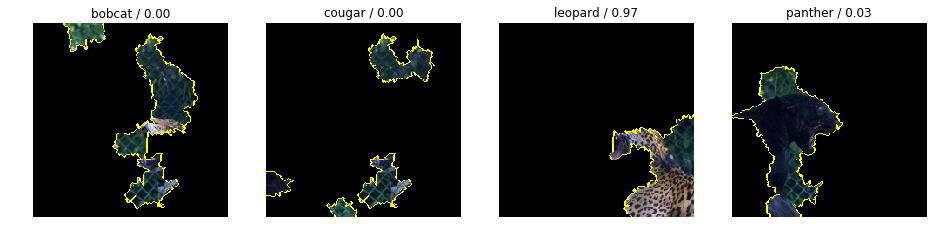

In [120]:
from skimage.segmentation import mark_boundaries

def explain_with_lime(justifier, img, **kwargs):
    classes = learn.data.classes
    _, _, probs = learn.predict(img)
    
    f = plt.figure(figsize=(16, 4))
    f.tight_layout()
    
    for i, c in enumerate(learn.data.classes):
        pred_idx = classes.index(c)
        sp = f.add_subplot(1, 4, i+1)
        title = "{} / {:.2f}".format(classes[pred_idx], probs[pred_idx])
        sp.set_title(title)
        sp.axis('off')

        temp, mask = justifier.get_image_and_mask(pred_idx, **kwargs)
        plt.imshow(mark_boundaries(temp, mask), interpolation='nearest')
    
explain_with_lime(justifier, vision_img, positive_only=True, num_features=5, hide_rest=True)

### Exploration: tSNE

In [121]:
def get_layer_activations(learn, layer_num=-4):
    layers = torch_core.flatten_model(learn.model)
    target_layer = layers[layer_num]
    custom_hook = callbacks.hook_output(target_layer)
    model = learn.model.eval()
    layer_acts = []
    
    for x, y in learn.data.valid_dl:
        model(x)
        layer_acts.append(custom_hook.stored.cpu().numpy())
    layer_acts = np.concatenate(layer_acts)
    return layer_acts

layer_acts = get_layer_activations(learn)

In [126]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, verbose=1).fit_transform(layer_acts)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.001s...
[t-SNE] Computed neighbors for 129 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 3.385928
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.138298
[t-SNE] Error after 1000 iterations: 0.560567


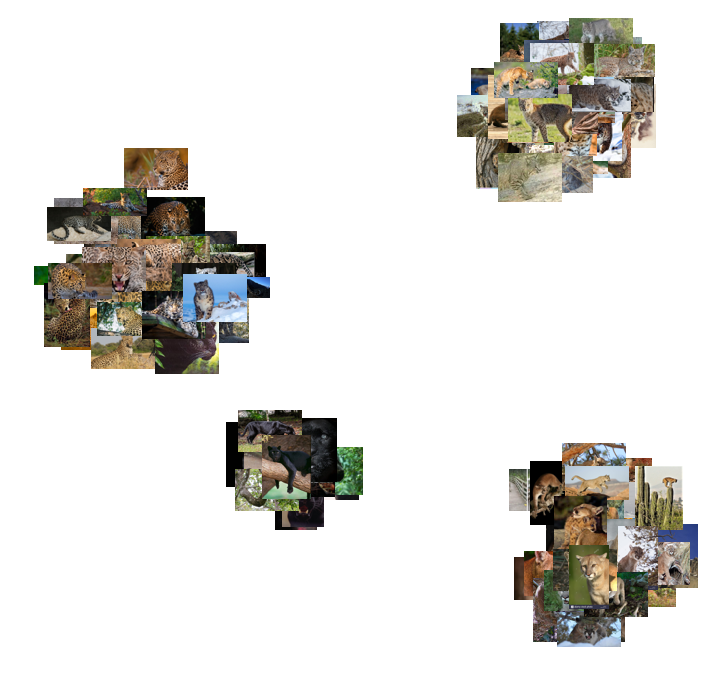

In [127]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter

def show_tsne_with_images(tsne, labels, figsize=(12, 12), image_zoom=1):
    fpaths = learn.data.valid_ds.items
    classes = learn.data.classes
    
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    xx = tsne[:, 0]
    yy = tsne[:, 1]
    colors = plt.cm.Set1.colors
    
    for i, (x, y) in enumerate(zip(xx, yy)):
        img = Image.open(fpaths[i])
        img.thumbnail((64, 64))
        
        im = OffsetImage(img, zoom=image_zoom)
        ab = AnnotationBbox(im, (x, y), xycoords="data", frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([xx,yy]))
    ax.autoscale()
    ax.axis('off')
    
    plt.show()
    
show_tsne_with_images(tsne, interp.y_true)

In [128]:
# https://github.com/kylemcdonald/CloudToGrid/blob/master/CloudToGrid.ipynb
import math
from scipy.spatial.distance import cdist
from lapjv import lapjv

def lap_from_tsne(tsne, num_images):
    grid = np.dstack(np.meshgrid(np.linspace(0, 1, num_images), np.linspace(0, 1, num_images))).reshape(-1, 2)
    cost_matrix = cdist(grid, tsne[:(num_images*num_images)], "sqeuclidean").astype(np.float32)
    return grid, lapjv(cost_matrix)[1]

num_images = math.floor(math.sqrt(len(data.valid_ds)))
grid, col_asses = lap_from_tsne(tsne, num_images)

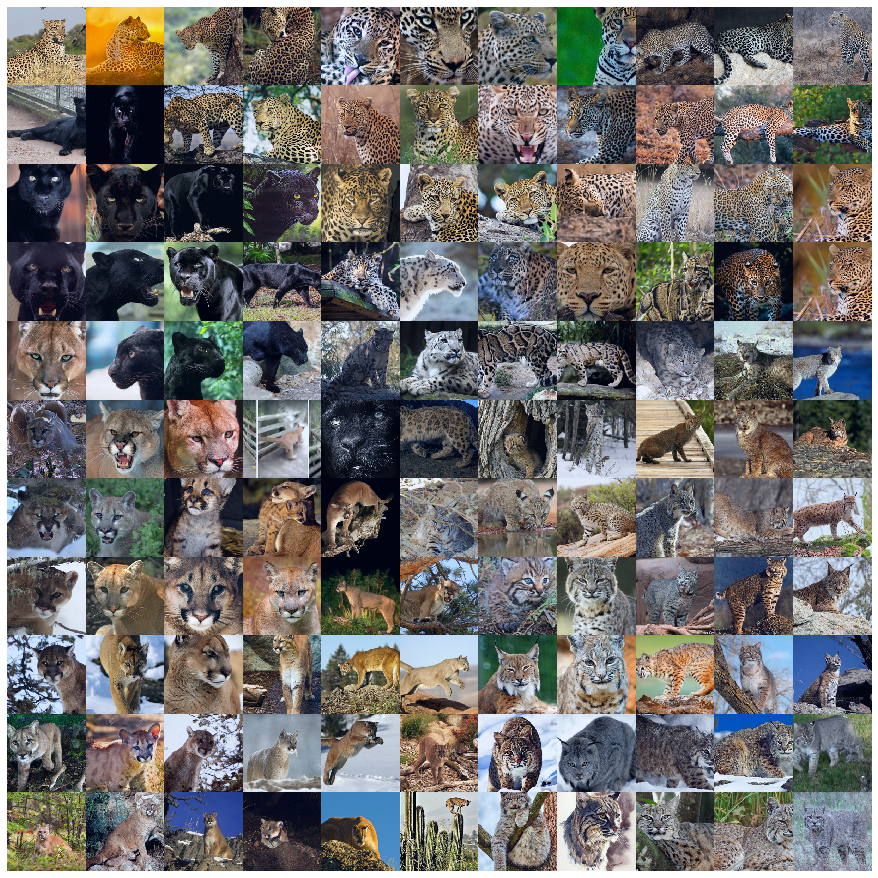

In [129]:
def show_lap_with_images(grid, col_asses, labels, figsize=(12, 12)):
    num_images = math.floor(math.sqrt(col_asses.shape[0]))
    grid_sorted = np.lexsort((grid[col_asses][:,1], grid[col_asses][:,0]))
    fpaths = learn.data.valid_ds.items
    classes = learn.data.classes
    
    f = plt.figure(figsize=figsize, frameon=False)
    f.tight_layout()
    
    for i, idx in enumerate(grid_sorted):
        ax = f.add_subplot(num_images, num_images, i+1)
        
        img_tensor = vision.image.open_image(fpaths[idx])
        img_tensor = learn.data.one_item(img_tensor)[0]
        img = image_from_tensor(img_tensor)
        ax.imshow(img, cmap='gray')
        
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

show_lap_with_images(grid, col_asses, interp.y_true)